# Figures for Yeager et al., 2025: Efficient Drift Correction of Initialized Earth System Predictions
### CESM2-SMYLE and E3SMv2.1-SMYLE Nino3.4 SST analysis

In [21]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
import os
import nc_time_axis
%matplotlib inline

# import plotting and other utilities 
# https://github.com/sgyeager/mypyutils
from mypyutils import calendar_utils as cal
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import regrid_utils as regrid
from mypyutils import io_utils as io
from mypyutils import stat_utils as stat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Dask Cluster

In [42]:
try:
    client.shutdown()
except:
    pass

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='32GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=32GB',
        account='P06010014',
        walltime='02:30:00',
        local_directory='/glade/derecho/scratch/yeager/',
        log_directory='/glade/derecho/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": 1.0,
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 
client

/glade/work/yeager/conda-envs/mypythonenv3/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36485 instead
  warnings.warn(


<Client: 'tcp://128.117.208.180:40487' processes=0 threads=0, memory=0 B>

### Read in CESM2-SMYLE TS monthly data

In [4]:
datadir = '/glade/derecho/scratch/yeager/YeagerEA_EffDriftCorr/data/'

In [5]:
cesm_smyle11 = xr.open_dataset(datadir+'CESM2-SMYLE_NOV.TS.1970-2020.nc').chunk({'M':1})
cesm_smyle11['TS'] = cesm_smyle11['TS'].astype('float32')

In [6]:
%%time
smyle11_seas = cal.mon_to_seas_dask(cesm_smyle11)

CPU times: user 1.48 s, sys: 184 ms, total: 1.66 s
Wall time: 13.9 s


### Read in E3SM2-SMYLE TS monthly data

In [7]:
e3sm_smyle11 = xr.open_dataset(datadir+'E3SMv2.1-SMYLE_NOV.TS.1970-2020.nc').chunk({'M':1})
e3sm_smyle11['TS'] = e3sm_smyle11['TS'].astype('float32')

In [9]:
%%time
e3sm_smyle11_seas = cal.mon_to_seas_dask(e3sm_smyle11)

CPU times: user 1.36 s, sys: 153 ms, total: 1.51 s
Wall time: 12.7 s


In [10]:
e3sm_smyle11_seas['lon'] = smyle11_seas['lon']
e3sm_smyle11_seas['lat'] = smyle11_seas['lat']

# Compute Regional-average SST

### Define Averaging Region

In [26]:
#lon-w, lon-e, lat-s, lat-n:
lonlats = [-170.,-120.,-5.,5.]  
regiontitle = 'Nino3.4'

latwgts = np.cos(np.deg2rad(cesm_smyle11['lat'].sel(lat=slice(lonlats[2],lonlats[3]))))

### Perform regional-average computation on SMYLE, returning xarray:

In [13]:
%%time
smyle11_seas_regsst = smyle11_seas['TS'].sel(lon=slice(lonlats[0],lonlats[1])).sel(lat=slice(lonlats[2],lonlats[3])).weighted(latwgts).mean(("lon", "lat")).load()

CPU times: user 3.21 s, sys: 260 ms, total: 3.47 s
Wall time: 20.4 s


In [14]:
%%time
e3sm_smyle11_seas_regsst = e3sm_smyle11_seas['TS'].sel(lon=slice(lonlats[0],lonlats[1])).sel(lat=slice(lonlats[2],lonlats[3])).weighted(latwgts).mean(("lon", "lat")).load()

CPU times: user 2.76 s, sys: 235 ms, total: 3 s
Wall time: 18.1 s


### Observed merged TS

In [27]:
cruhad = xr.open_dataset(datadir+'merged_CRU-TS4.05_HadISST.TS.1960-2020.fv09.nc').astype('float32')

In [35]:
tmp = cruhad['TS'].sel(lat=slice(lonlats[2],lonlats[3])).sel(lon=slice(lonlats[0]+360,lonlats[1]+360))
obs_mon = tmp.weighted(latwgts).mean(("lon", "lat"))

In [36]:
obs_seas = obs_mon.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

# Skill Analysis

In [19]:
smyle11_seas_time = smyle11_seas['time'].load()
e3sm_smyle11_seas_time = e3sm_smyle11_seas['time'].load()

In [22]:
%%time
# Remove leadtime-dependent climatology
climy0 = 1982
climy1 = 2016
smyle11_seas_regsst_dd,smyle11_seas_regsst_drift = stat.remove_drift(smyle11_seas_regsst,smyle11_seas_time,climy0,climy1)
e3sm_smyle11_seas_regsst_dd,e3sm_smyle11_seas_regsst_drift = stat.remove_drift(e3sm_smyle11_seas_regsst,e3sm_smyle11_seas_time,climy0,climy1)

CPU times: user 3.82 ms, sys: 0 ns, total: 3.82 ms
Wall time: 3.86 ms


In [38]:
%%time
# SMYLE seasonal skill
smyle11_seas_skill = stat.compute_skill_seasonal(smyle11_seas_regsst_dd,smyle11_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
e3sm_smyle11_seas_skill = stat.compute_skill_seasonal(e3sm_smyle11_seas_regsst_dd,e3sm_smyle11_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)

CPU times: user 524 ms, sys: 7.07 ms, total: 531 ms
Wall time: 900 ms


## Supplementary Figure 1

In [39]:
jan = obs_seas.time.dt.month==1
obs_djf = obs_seas.where(jan).dropna('time')
obs_djf = obs_djf - obs_djf.sel(time=slice("1982","2016")).mean('time')

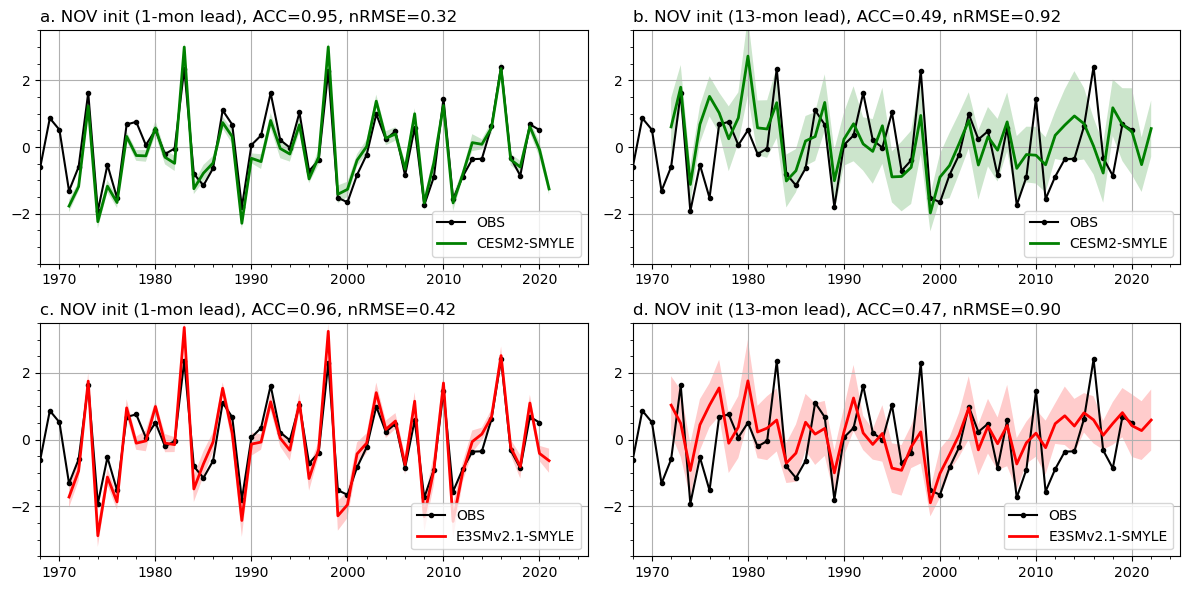

In [41]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(12,6))

nrow=2
ncol=2
plt.rcParams.update({'font.size': 10})

ax1 = fig.add_subplot(nrow,ncol,1)
ax1.set_ylim([-3.5,3.5])
ax1.set_yticks([-2,0,2])
ax1.set_yticks(np.arange(-3.5,4,0.5),minor=True)
ax1.set_xlim([1968,2025])
ax1.set_xticks(np.arange(1968,2026,2),minor=True)
ax1.plot(obs_djf.time.dt.year,obs_djf,color='k',marker='.',markersize=6,label='OBS')
        
Lindex = 0
lead = smyle11_seas_regsst_dd.isel(L=Lindex).L.values.item()-2
acc = smyle11_seas_skill.isel(L=Lindex).corr.values.item()
nrmse = smyle11_seas_skill.isel(L=Lindex).rmse.values.item()
data = smyle11_seas_regsst_dd.isel(L=Lindex).dropna('Y')
datatime = smyle11_seas_time.isel(L=Lindex).dropna('Y').dt.year
titl = 'NOV init ({0:d}-mon lead), ACC={1:3.2f}'.format(lead,acc)+', nRMSE='+'{0:3.2f}'.format(nrmse)
ax1.set_title('a. '+titl, loc='left')
ax1.plot(datatime,data.mean('M'),color='g',linewidth=2,label='CESM2-SMYLE')
datastd = data.std('M')
ymin = data.mean('M')-datastd; ymax = data.mean('M')+datastd
ax1.fill_between(datatime,ymin,ymax,fc='g',alpha=0.2)
ax1.legend(loc='lower right')
ax1.grid(True)

ax2 = fig.add_subplot(nrow,ncol,2)
ax2.set_ylim([-3.5,3.5])
ax2.set_yticks([-2,0,2])
ax2.set_yticks(np.arange(-3.5,4,0.5),minor=True)
ax2.set_xlim([1968,2025])
ax2.set_xticks(np.arange(1968,2026,2),minor=True)
ax2.plot(obs_djf.time.dt.year,obs_djf,color='k',marker='.',markersize=6,label='OBS')

Lindex = 4
lead = smyle11_seas_regsst_dd.isel(L=Lindex).L.values.item()-2
acc = smyle11_seas_skill.isel(L=Lindex).corr.values.item()
nrmse = smyle11_seas_skill.isel(L=Lindex).rmse.values.item()
data = smyle11_seas_regsst_dd.isel(L=Lindex).dropna('Y')
datatime = smyle11_seas_time.isel(L=Lindex).dropna('Y').dt.year
titl = 'NOV init ({0:d}-mon lead), ACC={1:3.2f}'.format(lead,acc)+', nRMSE='+'{0:3.2f}'.format(nrmse)
ax2.set_title('b. '+titl, loc='left')
ax2.plot(datatime,data.mean('M'),color='g',linewidth=2,label='CESM2-SMYLE')
datastd = data.std('M')
ymin = data.mean('M')-datastd; ymax = data.mean('M')+datastd
ax2.fill_between(datatime,ymin,ymax,fc='g',alpha=0.2)
ax2.legend(loc='lower right')
ax2.grid(True)

ax3 = fig.add_subplot(nrow,ncol,3)
ax3.set_ylim([-3.5,3.5])
ax3.set_yticks([-2,0,2])
ax3.set_yticks(np.arange(-3.5,4,0.5),minor=True)
ax3.set_xlim([1968,2025])
ax3.set_xticks(np.arange(1968,2026,2),minor=True)
ax3.plot(obs_djf.time.dt.year,obs_djf,color='k',marker='.',markersize=6,label='OBS')
        
Lindex = 0
lead = e3sm_smyle11_seas_regsst_dd.isel(L=Lindex).L.values.item()-2
acc = e3sm_smyle11_seas_skill.isel(L=Lindex).corr.values.item()
nrmse = e3sm_smyle11_seas_skill.isel(L=Lindex).rmse.values.item()
data = e3sm_smyle11_seas_regsst_dd.isel(L=Lindex).dropna('Y')
datatime = e3sm_smyle11_seas_time.isel(L=Lindex).dropna('Y').dt.year
titl = 'NOV init ({0:d}-mon lead), ACC={1:3.2f}'.format(lead,acc)+', nRMSE='+'{0:3.2f}'.format(nrmse)
ax3.set_title('c. '+titl, loc='left')
ax3.plot(datatime,data.mean('M'),color='r',linewidth=2,label='E3SMv2.1-SMYLE')
datastd = data.std('M')
ymin = data.mean('M')-datastd; ymax = data.mean('M')+datastd
ax3.fill_between(datatime,ymin,ymax,fc='r',alpha=0.2)
ax3.legend(loc='lower right')
ax3.grid(True)

ax4 = fig.add_subplot(nrow,ncol,4)
ax4.set_ylim([-3.5,3.5])
ax4.set_yticks([-2,0,2])
ax4.set_yticks(np.arange(-3.5,4,0.5),minor=True)
ax4.set_xlim([1968,2025])
ax4.set_xticks(np.arange(1968,2026,2),minor=True)
ax4.plot(obs_djf.time.dt.year,obs_djf,color='k',marker='.',markersize=6,label='OBS')
        
Lindex = 4
lead = e3sm_smyle11_seas_regsst_dd.isel(L=Lindex).L.values.item()-2
acc = e3sm_smyle11_seas_skill.isel(L=Lindex).corr.values.item()
nrmse = e3sm_smyle11_seas_skill.isel(L=Lindex).rmse.values.item()
data = e3sm_smyle11_seas_regsst_dd.isel(L=Lindex).dropna('Y')
datatime = e3sm_smyle11_seas_time.isel(L=Lindex).dropna('Y').dt.year
titl = 'NOV init ({0:d}-mon lead), ACC={1:3.2f}'.format(lead,acc)+', nRMSE='+'{0:3.2f}'.format(nrmse)
ax4.set_title('d. '+titl, loc='left')
ax4.plot(datatime,data.mean('M'),color='r',linewidth=2,label='E3SMv2.1-SMYLE')
datastd = data.std('M')
ymin = data.mean('M')-datastd; ymax = data.mean('M')+datastd
ax4.fill_between(datatime,ymin,ymax,fc='r',alpha=0.2)
ax4.legend(loc='lower right')
ax4.grid(True)

        

fig.tight_layout()
plt.savefig('Fig_supp01.png')